In [ ]:
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# statistics
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [ ]:
data = pd.read_csv("/content/PFE.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,37.286530,37.333965,36.888046,37.134724,34.333916,16514072
1,2020-01-03,36.736244,37.229603,36.688805,36.935486,34.149708,14922848
2,2020-01-06,36.831120,37.001900,36.717270,36.888046,34.105850,15771951
3,2020-01-07,37.115749,37.125237,36.698292,36.764706,33.991806,20108107
4,2020-01-08,36.774193,37.210625,36.764706,37.058823,34.263741,16403507
...,...,...,...,...,...,...,...
477,2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900
478,2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200
479,2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800
480,2021-11-26,54.040001,54.939999,53.250000,54.000000,54.000000,66561300


In [ ]:
data.set_index('Date', inplace=True)
data.index = pd.DatetimeIndex(data.index)

In [ ]:
tlen = len(data)-10 #Training data length
train = data[:tlen]
test = data[tlen:]

Text(0, 0.5, 'Closing')

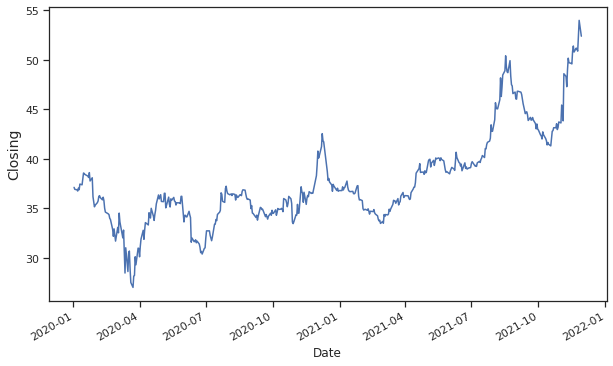

In [ ]:
# General view of the time series data
plt.figure(figsize=(10, 6))
plt.rcParams['axes.unicode_minus'] = False 
data["Close"].plot()
plt.xlabel('Date',fontsize=12,verticalalignment='top')
plt.ylabel('Closing',fontsize=14,horizontalalignment='center')


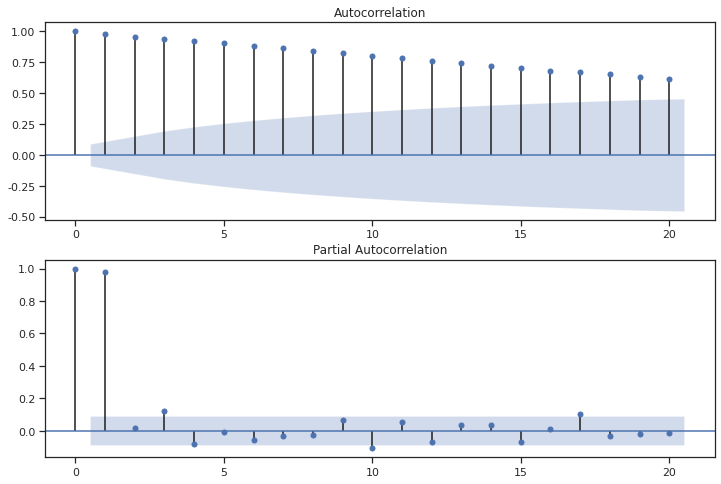

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data["Close"],lags=20,ax=ax1) #ACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Close'],lags=20,ax=ax2) #PACF
plt.show()

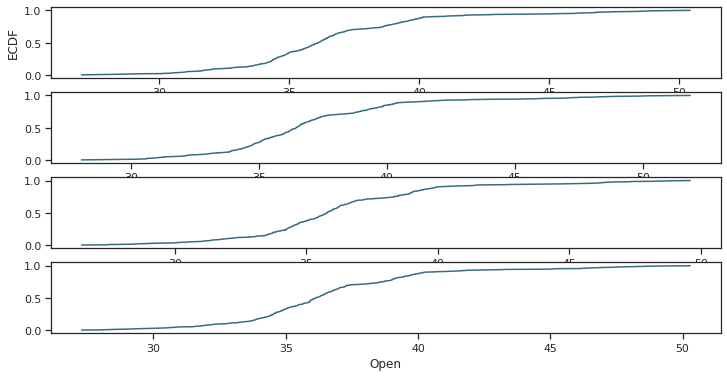

In [ ]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(411)
cdf = ECDF(train['Close'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Close'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(412)
cdf = ECDF(train['High'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('High');

# plot second ECDF  
plt.subplot(413)
cdf = ECDF(train['Low'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Low');

# plot second ECDF  
plt.subplot(414)
cdf = ECDF(train['Open'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Open');

In [ ]:
# Reference from https://www.kaggle.com/pratyushakar/time-series-analysis-using-arima-sarima
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [ ]:
# Reference from https://www.kaggle.com/pratyushakar/time-series-analysis-using-arima-sarima
from scipy import stats
from scipy.stats import normaltest
def residual_plot(model):

    resid = model.resid
    print(normaltest(resid))
    # returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
    # the residual is not a normal distribution

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    #Now plot the distribution using 
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')


    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

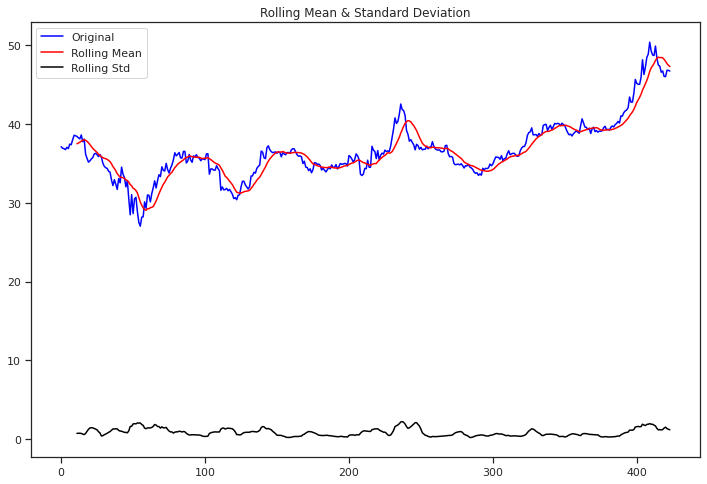

Results of Dickey-Fuller Test:
p-value = 0.7266. The series is likely non-stationary.
Test Statistic                  -1.070698
p-value                          0.726615
#Lags Used                      10.000000
Number of Observations Used    413.000000
Critical Value (1%)             -3.446283
Critical Value (5%)             -2.868564
Critical Value (10%)            -2.570511
dtype: float64


In [ ]:
test_stationarity(train['Close'])

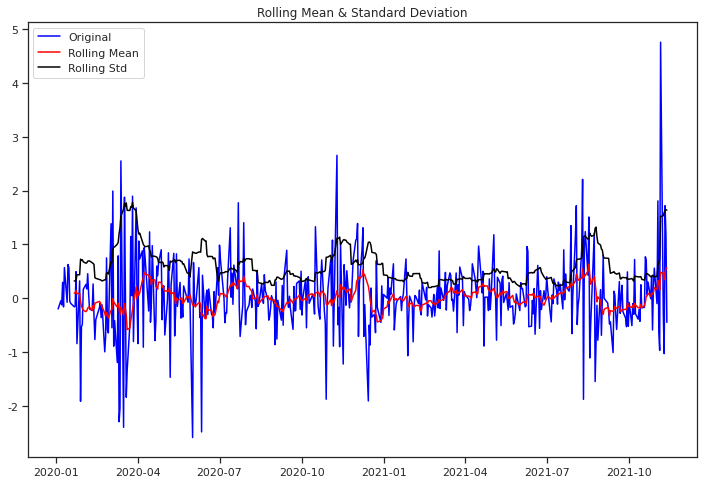

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.619401
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


In [ ]:
closes = train['Close']
first_diff_c = closes - closes.shift(1) # First-order differencing
first_diff_c = first_diff_c.dropna(inplace = False)
test_stationarity(first_diff_c, window = 12)

In [ ]:
bic_matrix = []
for p in [0,1,9]:
    temp= []
    for q in [0,1,9]:
        try:
            temp.append(ARIMA(closes, (p, 1, q)).fit().bic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix)  
p,q = bic_matrix.stack().idxmin()  
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))

BIC 最小的p值 和 q 值：0,1


In [ ]:
bic_matrix

,0,1,2
0,1015.130028,1012.846644,1038.428756
1,1013.303184,1019.001476,NaN
2,1031.788624,1036.402245,1079.188100


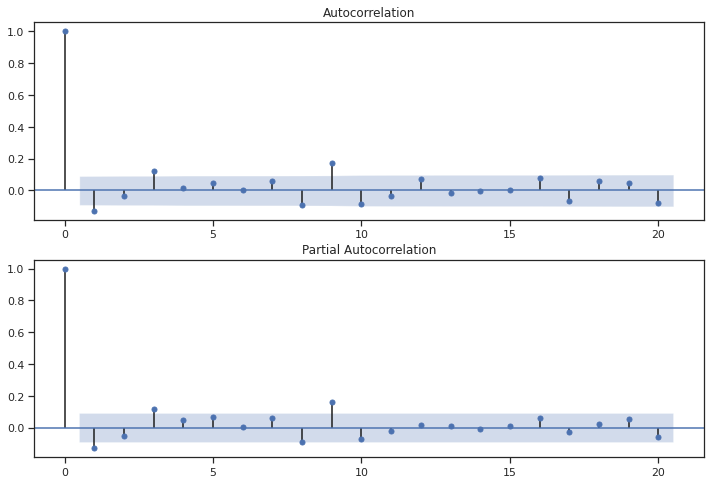

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff_c,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff_c,lags=20,ax=ax2)
plt.show()

In [ ]:
# Fit ARIMA model
arima_mod_a = ARIMA(closes, order=(0,1,1)).fit(disp=False)
print(arima_mod_a.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  471
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -497.191
Method:                       css-mle   S.D. of innovations              0.695
Date:                Tue, 30 Nov 2021   AIC                           1000.382
Time:                        20:50:18   BIC                           1012.847
Sample:                             1   HQIC                          1005.286
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0269      0.028      0.969      0.333      -0.027       0.081
ma.L1.D.Close    -0.1344      0.045     -3.000      0.003      -0.222      -0.047
                                    Root

NormaltestResult(statistic=91.26930442494863, pvalue=1.5174778499047453e-20)


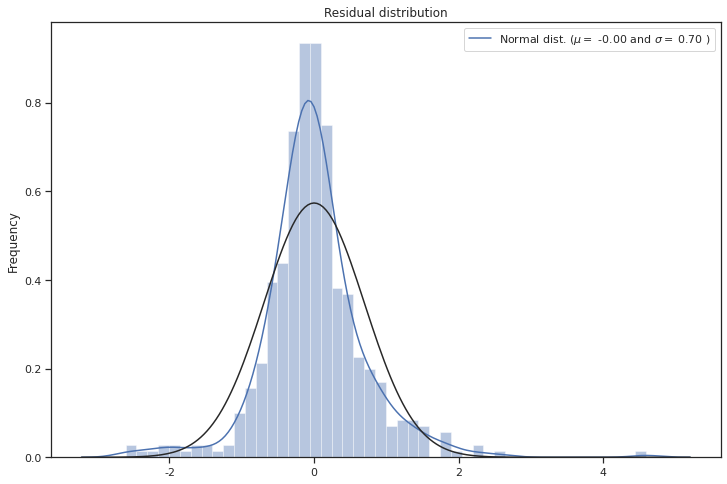

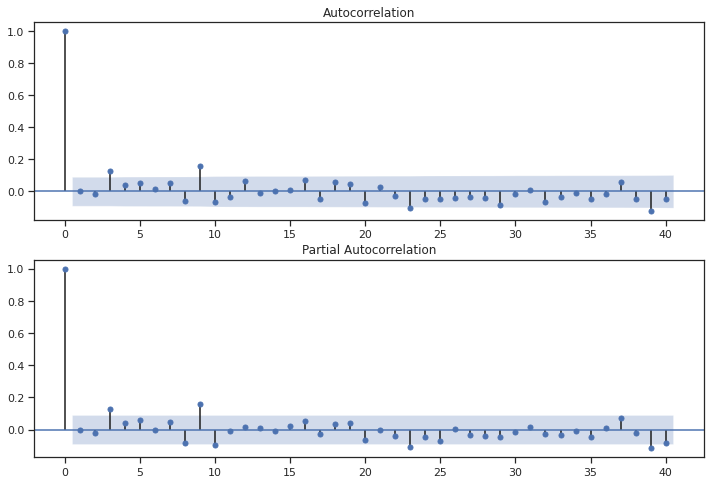

In [ ]:
residual_plot(arima_mod_a)

In [ ]:
from datetime import datetime
end = datetime(2022, 3, 1)
start = datetime(2021, 11, 13)
duration = end-start
print(duration.days)

108


In [ ]:
predict_d = arima_mod_a.forecast(109)[0] # Predict until 1st March 2022
print(predict_d)

pidx = pd.date_range(start,end,freq='d').to_series()
print(pidx)

predict_DF = pd.DataFrame(predict_d)
predict_DF.set_index(pidx, inplace=True)
predict_DF

[49.79674278 49.82363693 49.85053108 49.87742523 49.90431937 49.93121352
 49.95810767 49.98500182 50.01189597 50.03879012 50.06568427 50.09257841
 50.11947256 50.14636671 50.17326086 50.20015501 50.22704916 50.25394331
 50.28083745 50.3077316  50.33462575 50.3615199  50.38841405 50.4153082
 50.44220235 50.46909649 50.49599064 50.52288479 50.54977894 50.57667309
 50.60356724 50.63046139 50.65735553 50.68424968 50.71114383 50.73803798
 50.76493213 50.79182628 50.81872043 50.84561457 50.87250872 50.89940287
 50.92629702 50.95319117 50.98008532 51.00697947 51.03387361 51.06076776
 51.08766191 51.11455606 51.14145021 51.16834436 51.19523851 51.22213265
 51.2490268  51.27592095 51.3028151  51.32970925 51.3566034  51.38349755
 51.41039169 51.43728584 51.46417999 51.49107414 51.51796829 51.54486244
 51.57175659 51.59865073 51.62554488 51.65243903 51.67933318 51.70622733
 51.73312148 51.76001563 51.78690977 51.81380392 51.84069807 51.86759222
 51.89448637 51.92138052 51.94827467 51.97516881 52.

,0
2021-11-13,49.796743
2021-11-14,49.823637
2021-11-15,49.850531
2021-11-16,49.877425
2021-11-17,49.904319
...,...
2022-02-25,52.593734
2022-02-26,52.620628
2022-02-27,52.647523
2022-02-28,52.674417


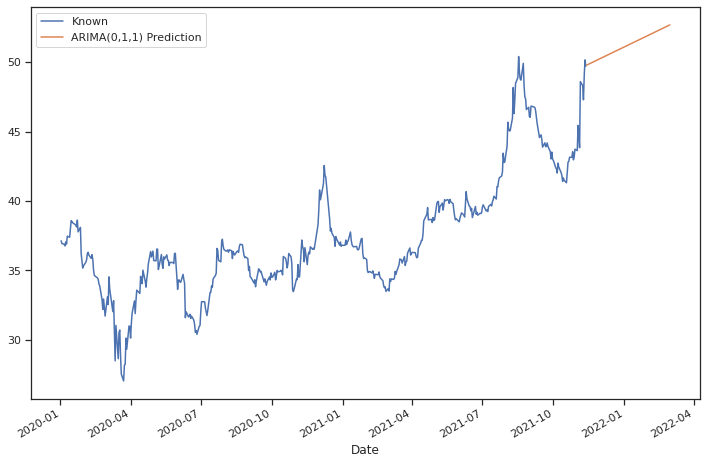

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
closes = train['Close']
ax = closes.plot(ax=ax)
predict_DF.plot(ax=ax)
# fig = arima_mod_a.plot_predict(start=datetime(2021,11,13), end=datetime(2022,3,1), dynamic=True, ax=ax, plot_insample=False)
plt.legend(['Known', 'ARIMA(0,1,1) Prediction'])
plt.show()